In [1]:
import os

dataset_path = "dataset"
if os.path.exists(dataset_path):
    print(f"Dataset folder found at {os.path.abspath(dataset_path)}")
else:
    print("❌ Dataset folder not found!")

Dataset folder found at d:\FYP Scoundscape\EE4228\Assignment 1 part 2 w PCA\dataset


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten image from 2D to 1D

PCA requires a vectorized representation of images.

Flattening a 480x480 grayscale image results in a 230,400-dimensional vector (since 480 × 480 = 230,400 pixels).

In [3]:
IMAGE_SIZE = (480, 480) #can change this 
THRESHOLD = 2000  #can change this parameter, distance threshold for recognition
DISTANCE_LOG = [] # log the distances for plotting of result
LABEL_LOG = []    # log the labels for plotting of result

def load_dataset(dataset_path):
    X, y, labels = [], [], []
    label_map = {}
    label_counter = 0
    for person_name in os.listdir(dataset_path):        
        person_path = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_path):
            continue
        if person_name not in label_map:
            label_map[person_name] = label_counter
            labels.append(person_name)
            label_counter += 1
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to read image at {img_path}. Skipping this file.")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            X.append(img.flatten())
            y.append(label_map[person_name])
    return np.array(X, dtype='float32'), np.array(y), labels

X, y, label = load_dataset("dataset")

In [4]:
# CHECK dataset X after normailization

df = pd.DataFrame(X)
df

,0,1,2,3,4,5,6,7,8,9,...,230390,230391,230392,230393,230394,230395,230396,230397,230398,230399
0,148.0,152.0,155.0,158.0,161.0,160.0,159.0,159.0,158.0,157.0,...,63.0,66.0,68.0,69.0,71.0,75.0,76.0,75.0,73.0,72.0
1,176.0,176.0,176.0,176.0,176.0,175.0,175.0,175.0,174.0,175.0,...,39.0,39.0,39.0,39.0,38.0,39.0,40.0,42.0,43.0,44.0
2,177.0,176.0,176.0,176.0,176.0,176.0,176.0,175.0,175.0,175.0,...,36.0,36.0,35.0,35.0,35.0,36.0,36.0,37.0,37.0,37.0
3,175.0,175.0,176.0,176.0,175.0,171.0,166.0,161.0,156.0,150.0,...,42.0,41.0,40.0,41.0,41.0,42.0,43.0,44.0,45.0,46.0
4,183.0,183.0,183.0,182.0,181.0,180.0,173.0,164.0,157.0,149.0,...,34.0,35.0,35.0,36.0,36.0,37.0,37.0,37.0,37.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,145.0,145.0,146.0,149.0,149.0,148.0,148.0,150.0,152.0,148.0,...,60.0,54.0,53.0,56.0,61.0,67.0,69.0,70.0,72.0,76.0
396,166.0,168.0,168.0,166.0,169.0,174.0,172.0,166.0,165.0,164.0,...,171.0,175.0,177.0,180.0,182.0,182.0,184.0,189.0,190.0,188.0
397,166.0,161.0,158.0,162.0,168.0,166.0,162.0,163.0,160.0,162.0,...,190.0,190.0,189.0,191.0,192.0,191.0,191.0,192.0,191.0,189.0
398,128.0,128.0,128.0,128.0,128.0,128.0,128.0,129.0,129.0,129.0,...,194.0,193.0,193.0,194.0,194.0,192.0,192.0,193.0,193.0,192.0


In [5]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,

In [6]:
label

['Ashley',
 'Fenella',
 'Kriti',
 'Megan',
 'Ranen',
 'Shu Yeen',
 'Ting Yu',
 'Wee Kian']

# Apply PCA to reduce dimensionality manually

### PCA Concept Recap
PCA (Principal Component Analysis) reduces high-dimensional data by finding the most important patterns (principal components).
Normally, PCA follows these steps:

a) Mean Centering - Calculate the mean image by averaging pixel values across all images.
Subtract this mean image from each image vector to center the data around the origin (each pixel across all images) before applying PCA. 

b) Compute the Covariance Matrix - Measures relationships between features (pixels) and identifies the directions of maximum variance within the dataset.

c) Eigen Decomposition - Finds eigenvectors & eigenvalues of the covariance matrix.

Eigenvalues: Represent the amount of variance captured. Determine the importance of each principal component. 

d) Select Principal Components - Find the N component of PCA to reduce dimensions while keeping the most information.

e) Project Data onto Principal Components – Apply the N component of the PCA found to the dataset.

### a) Mean Centering - Calculate the mean image by averaging pixel values across all images.
Subtract this mean image from each image vector to center the data around the origin (each pixel across all images) before applying PCA. 

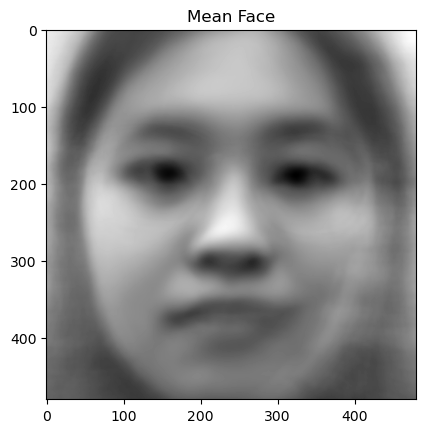

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X is a 2D array (num_images x num_features) and is a Pandas DataFrame
# Let's say the original images are height x width
height = 480  # Replace with your image height
width = 480   # Replace with your image width

# Step 1: Compute the mean face
mean_face = np.mean(X, axis=0)  # Compute mean for each pixel across all images

# Step 2: If `mean_face` is a Pandas Series, convert it to a NumPy array
mean_face = np.array(mean_face)  # Convert to a NumPy array if it's a Series

# Step 3: Reshape the mean face back into the image dimensions
mean_face_image = mean_face.reshape(height, width)

# Plot the mean face
plt.imshow(mean_face_image, cmap='gray')
plt.title('Mean Face')
plt.axis('on')  # Hide the axis for cleaner visualization
plt.show()

### b) Calculation of difference between training vector and mean vector

To normalize the training set, we just simply need to subtract for each picture in the training set the mean that was calculated in the previous step.

The reason why this is necessary is because we want to create a system that is able to represent any face. Therefore, we calculated the elements that all faces have in common (the mean). If we extract this average from the pictures, the features that distinguish each picture from the rest of the set are visible.

In [8]:
# Step 4: Center the data by subtracting the mean face
X_centered = X - mean_face

print("Mean of X_centered:", np.mean(X_centered))
print("Variance of X_centered:", np.var(X_centered, axis=0))

Mean of X_centered: -3.1195746e-08
Variance of X_centered: [1350.121  1348.8921 1350.7308 ... 3566.0234 3558.7412 3555.1797]


### c) Covariance Matrix Computation

Compute the covariance matrix of the centered data to understand the variance and relationships between different pixel values.

The covariance matrix shows how each feature varies with every other feature.

In [9]:
#cov_matrix = np.dot(X_centered, X_centered.T)

cov_matrix=np.cov(X_centered)
#cov_matrix = np.divide(cov_matrix,25.0)
print('Covariance Matrix Shape:', cov_matrix.shape)
print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance Matrix Shape: (400, 400)
Covariance matrix of X: 
[[1095.5509706   521.3843401   705.91175539 ... -640.60561693
  -764.74464771 -327.27676029]
 [ 521.3843401  1491.08650691 1095.05467311 ... -589.60868259
  -638.15424424 -380.86062631]
 [ 705.91175539 1095.05467311 1493.85461645 ... -818.23587601
  -978.72954651 -475.95749112]
 ...
 [-640.60561693 -589.60868259 -818.23587601 ... 1634.89894921
  1425.98284775  713.38499935]
 [-764.74464771 -638.15424424 -978.72954651 ... 1425.98284775
  1982.63506554 1109.34606982]
 [-327.27676029 -380.86062631 -475.95749112 ...  713.38499935
  1109.34606982 1759.20120744]]


### d) Eigenvector of covariance

From the covariance we can extract the eigenvectors. The general idea is that eigenvectors are the vectors of the covariance that describe the direction of the data.

Eigenvectors: Directions in the feature space (like axes) along which the data varies the most.

Eigenvalues: Tell you how much variance is in each direction (eigenvector).

In [10]:
#eigenvalues and eigenvectors
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('eigenvalues.shape: {} eigenvectors.shape: {}'.format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (400,) eigenvectors.shape: (400, 400)


In [11]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = eigenvectors[sorted_ind]
train_set_files_sort = np.array(X)[sorted_ind]

## d) Select Principal Components - Find the N component of PCA to reduce dimensions while keeping the most information.

Find the directions (eigenvectors) where the data varies the most.

Keep only the top ones (with the biggest eigenvalues) to reduce dimensionality while preserving the most important information.

Number of components needed to explain 95.5% of the variance: 120
Cumulative variance explained with 120 components: 0.9551


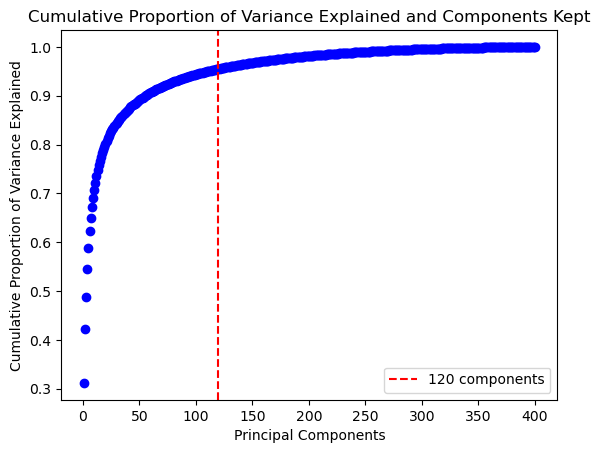

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming eigvalues_sort is already computed and contains the sorted eigenvalues
var_comp_sum = np.cumsum(eigvalues_sort) / sum(eigvalues_sort)

# Define the threshold of variance you want to keep, e.g., 95%
threshold = 0.955

# Find the number of components needed to explain at least the threshold percentage of variance
n_components = np.argmax(var_comp_sum >= threshold) + 1  # Adding 1 because index starts at 0

# Print the number of components and the corresponding cumulative variance
print(f"Number of components needed to explain {threshold*100}% of the variance: {n_components}")
print(f"Cumulative variance explained with {n_components} components: {var_comp_sum[n_components-1]:.4f}")

# Plot the cumulative variance explained by each principal component
num_comp = range(1, len(eigvalues_sort) + 1)
plt.title('Cumulative Proportion of Variance Explained and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.scatter(num_comp, var_comp_sum, color='blue')
plt.axvline(x=n_components, color='red', linestyle='--', label=f'{n_components} components')
plt.legend(loc='best')
plt.show()

### e) Project Data onto Principal Components – Apply the N component of the PCA found to the dataset.

In [14]:
def pca(X, num_components):
    mean_face = np.mean(X, axis=0)
    X_centered = X - mean_face
    cov_matrix = np.dot(X_centered, X_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    eigvecs = np.dot(X_centered.T, eigvecs)
    eigvecs = eigvecs[:, ::-1]  # descending order
    eigvecs = eigvecs[:, :num_components]
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)

    # Explained variance
    explained_variance = np.var(np.dot(X_centered, eigvecs), axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)

    return mean_face, eigvecs, X_centered, explained_variance_ratio

def project(X, mean, eigenfaces):
    return np.dot(X - mean, eigenfaces)

## Training PCA with N components

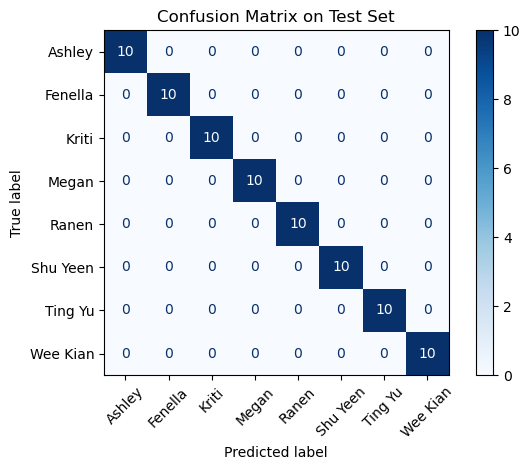

Accuracy (1 for 100%): 1.0


In [15]:
from sklearn.model_selection import train_test_split
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #can change test_size

# PCA on training data
num_pca_components = 120                           
mean_face, eigenfaces, X_train_centered, evr = pca(X_train, num_components=num_pca_components)
X_train_pca = project(X_train, mean_face, eigenfaces)

# Project test data
X_test_pca = project(X_test, mean_face, eigenfaces)

# Predict test set using PCA projections
y_pred = []
for test_vec in X_test_pca:
    distances = np.linalg.norm(X_train_pca - test_vec, axis=1)
    best_match_idx = np.argmin(distances)
    pred_label = y_train[best_match_idx]
    y_pred.append(pred_label)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label[i] for i in np.unique(y)])
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

print(f"Accuracy (1 for 100%): {acc}")

In [15]:
X_train_pca

array([[ 38.699028  ,  -2.013422  ,  21.223238  , ...,  -1.7350891 ,
          1.7162409 ,   0.3709985 ],
       [-78.535034  , -35.67539   ,   9.978098  , ...,  -0.27164948,
          0.805532  ,  -1.7050967 ],
       [ 26.63665   , -11.201199  ,  -2.3038642 , ...,   1.001945  ,
         -0.41007257,  -0.9186669 ],
       ...,
       [-57.10141   , -23.363972  , -42.518787  , ...,   1.6422309 ,
          0.81587124,  -0.797216  ],
       [ 47.043045  ,   7.033475  ,  10.822237  , ...,   0.8699886 ,
         -0.48136416,  -0.6226778 ],
       [ 23.764448  ,  -6.365841  ,   0.23261738, ...,   0.47915405,
          0.9488569 ,   0.48870265]], dtype=float32)

In [16]:
X_test_pca

array([[ 62.59101   ,   2.258461  , -12.166197  , ...,  -0.845031  ,
         -0.89681184,   1.0044963 ],
       [ 52.852196  ,  22.720459  ,   5.3174095 , ...,   1.6581908 ,
          1.1973388 ,  -1.2484739 ],
       [-40.063454  ,  -7.7387204 ,  38.25007   , ...,   0.3987063 ,
          1.2189577 ,   1.1573944 ],
       ...,
       [ 11.028807  , -19.13734   , -21.21281   , ...,   0.771271  ,
         -0.49846876,   0.64603055],
       [-24.105303  ,   2.8921943 ,  -8.75479   , ...,   1.9190176 ,
         -0.2141107 ,   0.277665  ],
       [ 50.00167   ,  10.324732  ,  12.502447  , ...,   0.7189971 ,
         -0.8991018 ,  -0.32385707]], dtype=float32)

## Eigenface and Weights to form a reconstructed face image (weighted sum)

once we get the Eigenface and weights, the reconstructed face known to be 'X_train_pca' and 'X_test_pca'.

### Eigenfaces

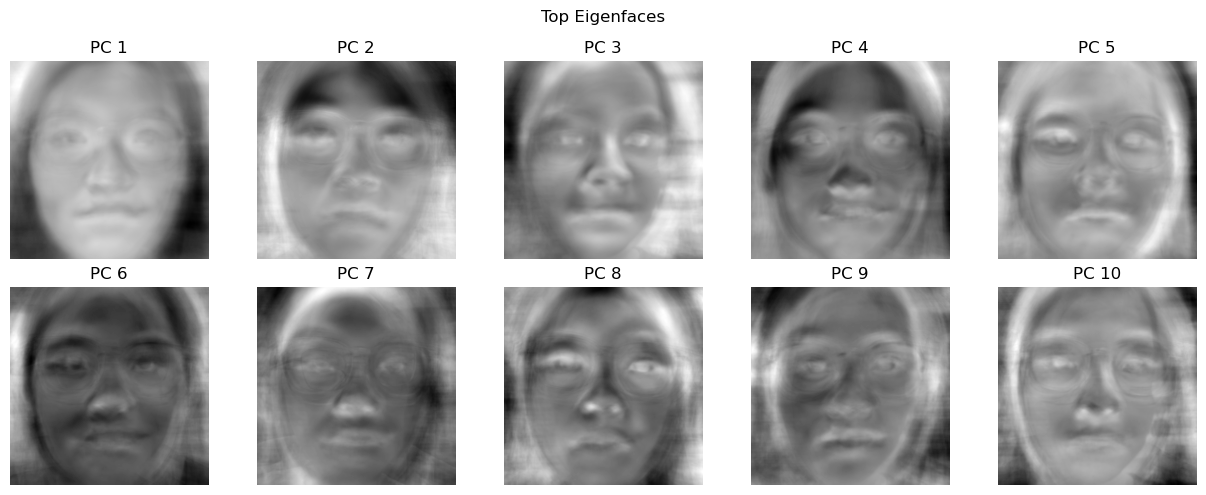

In [17]:
def show_top_eigenfaces(eigenfaces, num):
    rows = 2
    cols = (num+1)//2
    plt.figure(figsize=(2.5*cols, 5))
    for i in range(num):
        plt.subplot(rows, cols, i+1)
        eig_img = eigenfaces[:, i].reshape(IMAGE_SIZE)
        plt.imshow(eig_img, cmap='gray')
        plt.title(f'PC {i+1}')
        plt.axis('off')
    plt.suptitle("Top Eigenfaces")
    plt.tight_layout()
    plt.show()

show_top_eigenfaces(eigenfaces, num=10)

### Get weights

In [18]:
# PCA on training data
num_pca_components = 120                            # Number of principal components (eigenfaces)
mean_face, eigenfaces, X_train_centered, evr = pca(X_train, num_components=num_pca_components)
X_train_pca = project(X_train, mean_face, eigenfaces)  # Project training data onto PCA space

# Project test data
X_test_pca = project(X_test, mean_face, eigenfaces)   # Project test data onto PCA space

# For a given image, the weight vector is the projection of the image onto the eigenfaces
image_idx = 1  # Example: Let's look at the first image's weight vector
image_weight_vector = X_train_pca[image_idx]
print(f"Weight vector for image {image_idx}: {image_weight_vector}")

# Similarly, for the test data
X_test_pca = project(X_test, mean_face, eigenfaces)  # Project test data onto PCA space
test_idx = 0  # Example: Let's look at the first test image's weight vector
test_image_weight_vector = X_test_pca[test_idx]

print(f"Weight vector for test image {test_idx}:{test_image_weight_vector}")

Weight vector for image 1: [-7.85350342e+01 -3.56753883e+01  9.97809792e+00  1.62815170e+01
 -1.12608166e+01  5.49771011e-01  7.18336105e-01  6.62732697e+00
  5.83980370e+00 -2.13264389e+01  1.37282073e+00 -6.00374126e+00
  2.70658827e+00 -6.40116644e+00  6.66582012e+00  6.48472214e+00
  6.07970810e+00 -1.20043678e+01 -5.80395937e+00  3.55556870e+00
 -2.47332954e+00  2.55944705e+00  1.54806185e+01  9.68256378e+00
 -5.00017357e+00  2.42599869e+00 -2.02198458e+00 -1.40196598e+00
 -1.02264774e+00  6.32620335e+00  3.40238976e+00  8.55354249e-01
 -3.06933069e+00 -2.34580040e-02  3.81648326e+00  4.16177082e+00
  1.26127088e+00 -7.47240305e-01  1.68084097e+00  1.95224237e+00
  1.52778912e+00  2.97060037e+00  1.07345414e+00 -8.26551914e-01
 -1.16005516e+00 -7.24698305e-01  1.95995009e+00  8.00851047e-01
 -8.54044199e-01  1.21295452e-01 -1.25001502e+00  2.48787451e+00
  1.32635069e+00  1.14295471e+00 -2.31509805e+00 -1.59319544e+00
 -2.42707992e+00  1.90896785e+00  8.74874711e-01  2.49654412e+0

### Reconstructed_face for train

X_train_pca contains the weights (projections) of faces in PCA space.

To reconstruct the original image, you multiply the weights by the eigenfaces and add back the mean face.

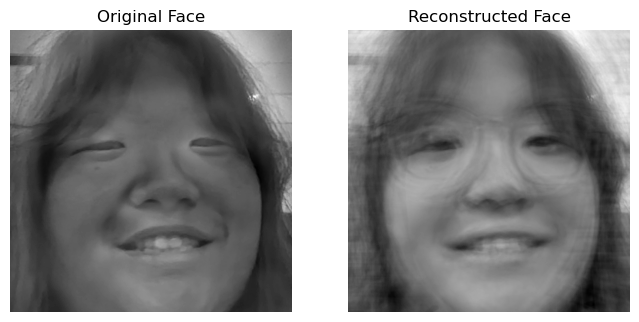

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the original face after mean centering
Original = X_train - mean_face

# Reconstruct the face from PCA weights
reconstructed_face = mean_face + np.dot(X_train_pca, eigenfaces.T)

# Ensure the original and reconstructed face are reshaped correctly
image_size = (480, 480)  # Change based on your dataset
index = 0 # Change to the index of the image you want to visualize
original_face_reshaped = Original[index].reshape(image_size)                
reconstructed_face_reshaped = reconstructed_face[index].reshape(image_size) 

# Show the original and reconstructed face
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(original_face_reshaped, cmap='gray')
ax[0].set_title("Original Face")
ax[0].axis("off")

ax[1].imshow(reconstructed_face_reshaped, cmap='gray')
ax[1].set_title("Reconstructed Face")
ax[1].axis("off")

plt.show()


In [ ]:
# Use this to find the pictures for the train dataset

y_train

array([3, 4, 1, 5, 3, 2, 6, 1, 7, 4, 7, 7, 5, 3, 3, 7, 3, 2, 2, 5, 3, 7,
       0, 4, 7, 6, 1, 4, 6, 6, 0, 5, 3, 1, 7, 5, 2, 4, 2, 1, 6, 7, 7, 4,
       1, 5, 4, 3, 0, 0, 1, 1, 7, 0, 6, 6, 4, 5, 3, 0, 1, 4, 5, 4, 6, 2,
       3, 0, 2, 5, 2, 0, 3, 6, 1, 4, 7, 5, 1, 0, 5, 7, 2, 1, 0, 3, 3, 7,
       5, 5, 2, 6, 7, 2, 3, 7, 1, 3, 0, 1, 4, 5, 1, 6, 1, 6, 7, 5, 4, 7,
       0, 5, 6, 7, 1, 0, 1, 4, 3, 0, 5, 4, 0, 2, 7, 5, 7, 4, 5, 4, 4, 6,
       6, 1, 2, 6, 1, 7, 3, 0, 4, 4, 5, 7, 6, 2, 2, 1, 5, 0, 0, 6, 6, 6,
       6, 0, 5, 7, 2, 5, 1, 4, 0, 0, 5, 6, 6, 0, 2, 5, 0, 3, 4, 5, 0, 2,
       5, 5, 6, 4, 0, 4, 7, 3, 1, 2, 7, 3, 2, 2, 4, 7, 6, 2, 0, 2, 2, 0,
       3, 1, 2, 5, 3, 0, 1, 1, 1, 4, 5, 1, 1, 0, 6, 4, 4, 7, 4, 6, 7, 4,
       4, 3, 3, 2, 5, 3, 3, 7, 0, 1, 0, 0, 0, 6, 7, 6, 7, 7, 3, 5, 7, 0,
       6, 6, 0, 0, 7, 5, 0, 2, 0, 2, 4, 6, 5, 6, 5, 5, 2, 7, 7, 5, 4, 2,
       7, 3, 1, 6, 1, 4, 4, 5, 2, 1, 2, 3, 2, 5, 0, 3, 7, 3, 3, 6, 2, 5,
       7, 2, 6, 2, 3, 3, 3, 2, 3, 6, 3, 1, 6, 4, 2,

### Reconstructed_face for Test

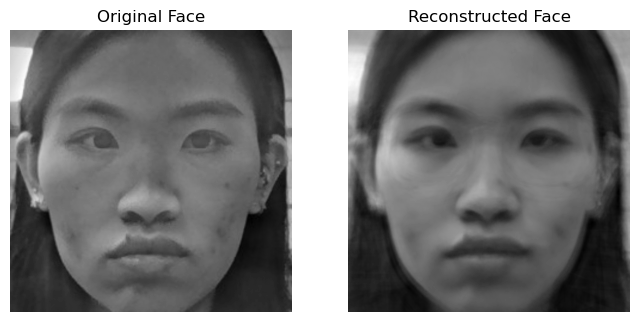

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the original face after mean centering
Original = X_test - mean_face

# Reconstruct the face from PCA weights
reconstructed_face = mean_face + np.dot(X_test_pca, eigenfaces.T)

# Ensure the original and reconstructed face are reshaped correctly
image_size = (480, 480)  # Change based on your dataset
index = 0 # Change to the index of the image you want to visualize
original_face_reshaped = Original[index].reshape(image_size)                
reconstructed_face_reshaped = reconstructed_face[index].reshape(image_size) 

# Show the original and reconstructed face
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(original_face_reshaped, cmap='gray')
ax[0].set_title("Original Face")
ax[0].axis("off")

ax[1].imshow(reconstructed_face_reshaped, cmap='gray')
ax[1].set_title("Reconstructed Face")
ax[1].axis("off")

plt.show()

In [50]:
# Use this to find the pictures for the test dataset

y_test

array([5, 4, 2, 3, 5, 4, 5, 7, 3, 6, 2, 2, 4, 1, 3, 4, 6, 0, 7, 0, 5, 7,
       6, 6, 6, 1, 1, 5, 2, 7, 4, 2, 7, 4, 1, 7, 4, 7, 0, 3, 2, 3, 3, 3,
       7, 0, 1, 4, 6, 4, 0, 1, 6, 1, 1, 5, 0, 5, 6, 3, 2, 5, 0, 3, 0, 0,
       5, 2, 0, 7, 7, 2, 5, 6, 2, 1, 4, 1, 6, 3])

# Apply LDA

LDA (Linear Discriminant Analysis) finds discriminative directions that maximize class separation, directions in feature space that best separate your classes.

LDA steps:

1) Compute the mean for each class and the overall mean of the dataset.

2) Compute the within-class covariance matrix by measuring the scatter of data points within the class means.

3) Compute the between-class covariance matrix by measuring the scatter between different class means.

4) Compute the eigenvalues and eigenvectors of the covariance matrices.

   Eigenvalues define the importance of each direction while the Eigenvectors define the direction of the face feature.

5) Determine the linear discrimination functions using the eigenvectors to form a transformation matrix.

6) Construct a decision surface for classification.


In [ ]:
'''
import numpy as np

def lda(X_proj, y, k=7):  # Add k for number of dimensions to reduce to
    class_labels = np.unique(y)

    # Global mean
    mean_total = np.mean(X_proj, axis=0)

    # Within-class scatter matrix (Sw)
    Sw = np.zeros((X_proj.shape[1], X_proj.shape[1]))

    # Between-class scatter matrix (Sb)
    Sb = np.zeros((X_proj.shape[1], X_proj.shape[1]))

    for c in class_labels:
        Xc = X_proj[y == c]

        # Calculate Within-class scatter (Sw) within each class mean
        mean_class = np.mean(Xc, axis=0)
        Sw += np.dot((Xc - mean_class).T, (Xc - mean_class))
        n_c = Xc.shape[0]

        # Calculate Between-class scatter (Sb) between class mean and global mean
        mean_diff = (mean_class - mean_total).reshape(-1, 1)
        Sb += n_c * np.dot(mean_diff, mean_diff.T)

    # Compute the eigenvalues and eigenvectors of the covariance matrices.
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    # Sort the eigenvectors by eigenvalues in decreasing order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Select the top k eigenvectors
    eigvecs_k = eigvecs[:, :k]

    # Project the data onto the selected eigenvectors
    X_lda = np.dot(X_proj, eigvecs_k)

    return X_lda

X_train_lda = lda(X_train_pca, y_train)
X_train_lda 

# X_train_lda = X_train_lda
'''

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def lda(X_proj, y):
    class_labels = np.unique(y)

    # Gobal mean
    mean_total = np.mean(X_proj, axis=0)

    # Within-class scatter matrix
    Sw = np.zeros((X_proj.shape[1], X_proj.shape[1]))

    # Between-class scatter matrix
    Sb = np.zeros((X_proj.shape[1], X_proj.shape[1]))


    for c in class_labels:
        Xc = X_proj[y == c]

        # Calculate Within-class scatter (Sw) within each class mean
        mean_class = np.mean(Xc, axis=0)
        Sw += np.dot((Xc - mean_class).T, (Xc - mean_class))
        n_c = Xc.shape[0]

        # Calculate Between-class scatter (Sb) within each class mean
        mean_diff = (mean_class - mean_total).reshape(-1, 1)
        Sb += n_c * np.dot(mean_diff, mean_diff.T)


    # Compute the eigenvalues and eigenvectors of the covariance matrices.
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    # Sort the eigenvectors by eigenvalues in decreasing order
    eigvecs = eigvecs[:, eigvals.argsort()[::-1]]
    
    return eigvecs.real

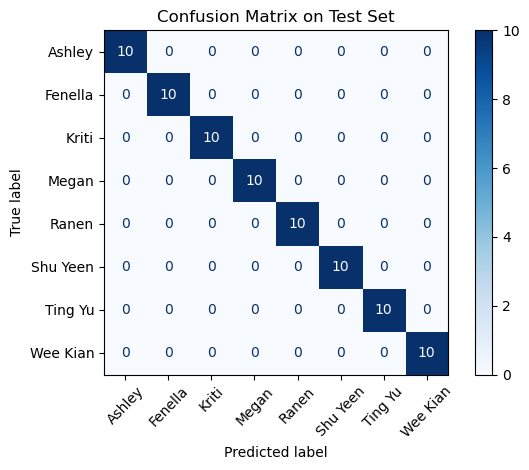

Accuracy (1 for 100%): 1.0


In [ ]:
# LDA on training data
lda_transform = lda(X_train_pca, y_train)

#In Linear Discriminant Analysis (LDA), the number of LDA components (also called discriminant axes) you can have is at most C−1, where 𝐶 is the number of classes.
#In our dataset we have 8 classes (0 -7): C = 8, C-1 = 7, so 7 components
num_lda_components = len(np.unique(y_train)) - 1
# Select the top k eigenvectors
lda_transform = lda_transform[:, :num_lda_components]

# Project the data onto the selected eigenvectors
X_train_lda = np.dot(X_train_pca, lda_transform)

# Project test data
X_test_lda = np.dot(X_test_pca, lda_transform)

# Predict test set
y_pred = []
for test_vec in X_test_lda:
    distances = np.linalg.norm(X_train_lda - test_vec, axis=1)
    best_match_idx = np.argmin(distances)
    pred_label = y_train[best_match_idx]
    y_pred.append(pred_label)


# Accuracy
acc = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label[i] for i in np.unique(y)])
disp.plot(xticks_rotation=46, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

print(f"Accuracy (1 for 100%): {acc}")

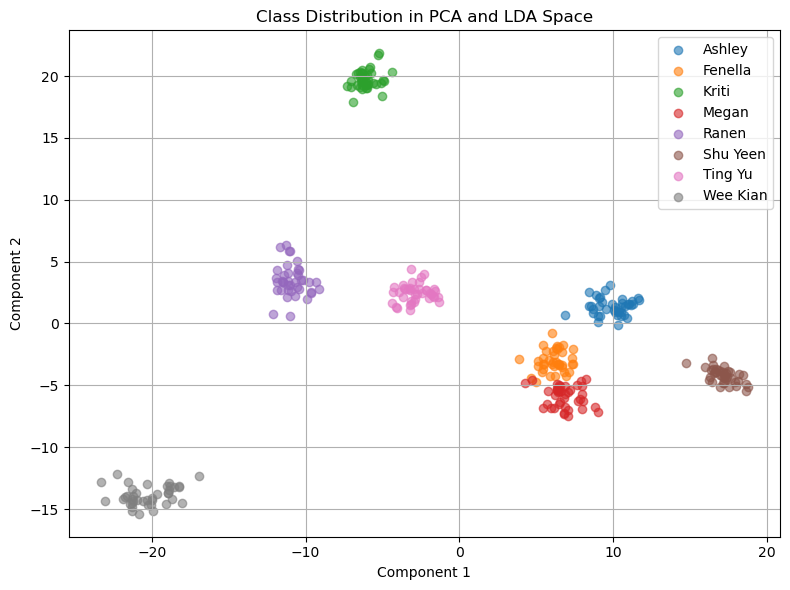

In [17]:
def plot_pca_class_distribution(X_pca, y, label_names):
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(
            X_pca[y == label, 0],
            X_pca[y == label, 1],
            label=label_names[label],
            alpha=0.6
        )
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Class Distribution in PCA and LDA Space")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca_class_distribution(X_train_lda, y_train, label)

PCA reduces noise and dimensionality

LDA improves classification